# Various probabilistic planning methods
#### Jiří Němeček

*NOTE: I did not export this to a PDF because that makes all font black, and that is difficult to see on the maze visualizations. It also doesn't show arrows that are essential for visualizing the policy. By viewing this in a dark mode, you will see it as I did.*

*PDF export introduced unnecessary confusion in my first submission, so I decided to get rid of it.*

*I have also moved most of the visualization code to the `visualize.py` module.*

----------

This is a report for an assignment concerning comparisons of a few planning methods for probabilistic environments. In particular, it compares the methods on a 2D maze environment with delay (negative reward) tiles and stochastic actions. More details are in the enclosed assignment PDF. 

This report consists of 2 parts:
 - Description of implementation details
 - Method comparison
 
## Implementation
My main intention in implementing this environment was to have everything as modular as possible while retaining some logical division of responsibilities of the classes.

First of all, there is a `Maze` class that parses a maze based on the file with its definition. It also overloads `__str__` method and creates a string representation that is useful to show in the terminal. Tile types are mapped on color, and we can optionally write some text into the tiles. The start is blue, the goal is green, the delay fields are red and the walls are white.

In [1]:
from maze import Maze
maze = Maze("dataset-assignment2/data/maze-7-A1.txt")
print(maze)

Afterwards, I have added a module `utils` with utilities facilitating the navigation in a maze. A class `Pos` serving more like a data type and a class `Dir` that implements turning logic. They also overload the `__str__` method to enable better viewing in the terminal.

In [2]:
from utils import Dir
print(Dir.NORTH, Dir.EAST, Dir.SOUTH, Dir.WEST)

▲ ► ▼ ◄


Another useful class is the `Engine` class that contains all game logic, with the implementation of the stochastic moves. It also contains a deterministic variant of the same actions that are required for some algorithms, such as FF-replavalue_iterationhen, there is a `Strategy` abstract class that has a single method to be overloaded, called `next_move`. This method is required by various testing functions in the `stat_tester` module. It must be implemented by all strategies in order to test them.

### FF - replan
In `ffreplan` module, there is a `FFReplan` class. It inherits from `Strategy` class. In its initializer, it computes a deterministic path to the goal. Then it can be run, and in case the agent diverges from its path and gets to a tile that is not on the shortest path, the path gets recomputed from the current position to the goal tile. This makes the runtime very slow on bigger mazes.

For computing the shortest path, an A* algorithm with Euclidean distance as a heuristic is used. Each transition has cost equal to $-reward$ in the originally posed problem. 

In [3]:
from engine import Engine
from ffreplan import FFReplan
from visualize import show_path

engine = Engine(maze)
ffreplan = FFReplan(engine)

show_path(engine, ffreplan)

Path was 24 steps long, Pepa made 8 total missteps (33.33%)
Total reward: 177
    5▼               
    6► 7► 8► 9►11▼   
               12▼   
         19▼17◄14◄   
         20▼         
         21►22►23▼   
                     



This visualization of directions and numbers serves the purpose of visualizing the path that the agent took. What is shown is the last time the agent was on the tile and the action it chose at that point. The time has always at most 2 digits (to make it readable), so it is considered timestep modulo 100.

### Value Iteration (VI)
Conversely, in `val_iter` module, there is a `ValueIteration` class that inherits from the `Strategy` class. Unlike FF-replan, it precomputes its entire policy in the initialization. It takes 2 additional parameters `gamma` and an optional `lim_residual`. 
 - `gamma` is the $\gamma$ in the classical sense as we know the algorithm, a kind of discount factor. 
 - `lim_residual` parameter sets the threshold of maximal residual in an iteration. 
If the maximal residual in one full iteration of VI algorithm goes bellow this threshold, we stop the algorithm and compute the policy. That is then stored as a dictionary, making the runtime very fast. 

The values $1-10^{-5}$ for `gamma` and $10^{-10}$ for `lim_residual` shown the best behavior in my tests. Higher values of `lim_residual` did not lead to convergence on big mazes. High values of `gamma` facilitate the propagation of the values through bigger mazes (state-spaces). It takes quite long to compute for big mazes (up to 5 minutes), but the runtime speed overweighs this. 

I did not realize that I could use `gamma`$ = 1$ since in previous cases whe I used VI, the environment was not defined with the all negative rewards and the only positive in the terminal

To facilitate the computation, the values are initialized on the ideal value if the actions were deterministic. That is done by performing a Dijkstra algorithm from the goal tile. The values are defined only for reachable tiles.

Because we have values of states (~tiles in this case), we can visualize them. Similarly, we can visualize the policy using the direction arrows shown earlier. The values of $V$ are rounded to integers.

In [4]:
from val_iter import ValueIteration

value_iteration = ValueIteration(engine, gamma=0.99999, lim_residual=1e-10)

print("Policy:")
value_iteration.show_policy(engine)

print("Value:")
value_iteration.show_value(engine)

show_path(engine, value_iteration)

Policy:
   ▼          
   ► ► ▲ ► ▼  
       ▼   ▼  
   ▼   ▼ ◄ ◄  
   ► ► ▼      
   ► ► ► ► ▼  
           ▲  

Value:
   172               
   174175177185186   
         191   188   
   190   193191189   
   192193194         
   193194196198199   
                0    

Path was 41 steps long, Pepa made 8 total missteps (19.51%)
Total reward: 160
    0▼               
    4►26►29▲30►31▼   
               32▼   
         35▼34◄33◄   
         36▼         
         38►39►40▼   
                     



An interesting thing to note is the policy decision of the agent to go north on the tile above the delay tile. This, in my testing (presented later), showed almost one point better on average than the straight strategy of the FF-replan algorithm. However, the result is not statistically relevant, even though the standard deviation of the reward of the VI is twice as low.

### Monte-Carlo Tree Search (MCTS)
Lastly, I have implemented a Monte-Carlo Tree Search algorithm in the `mtcs` module. The only parameter that can be set is `n_expansions`, the number of expansions in each node. By default, I estimated 20 to be a reasonable number, but the time was of the essence at this point, so after a quick "grid search", I settled for 10 for most of the tests. Interestingly, even just 4 showed results of similar quality on small, nice mazes. 

#### Different setups for different sizes
But when I did the full set of tests, I encountered problems with the agent getting lost in some mazes (those without walls). From that, I assumed that it is essential to run some tests with more exploration. Thus, **mazes of sizes 25 and 101** were recomputed with `n_expansions`$ = 20$. More tests were impossible due to time limitations. 

Instead of a random rollout, I use pre-computed values for each position. The values are exactly the same as for the initialization of VI, except the goal has a value of 200.

MCTS is an online method. Thus, only an execution path is relevant for visualization.

In [5]:
from mcts import MCTS

mcts = MCTS(engine, n_expansions=10)

show_path(engine, mcts)

Path was 33 steps long, Pepa made 8 total missteps (24.24%)
Total reward: 168
    1▼               
    2► 7► 8► 9►11▼   
               15▼   
         23▼22◄21◄   
         26▼         
         29►30►32▼   
                     



The path is sometimes nonsensical. I assume the randomness of the environment makes it quite difficult to converge to true values. For time reasons, I opted for speed of execution rather than quality of path chosen. On mazes `101-B` and `25-E`, it especially helped to go for 20 expansions even for the speed reasons, as the better decision making helped make fewer steps. Mostly though, the overhead of iterating in each position grew quadratically, so a lower number was preferred.

## Evaluation 
For evaluation, as mentioned before, there are a couple of methods in the `stat_tester` module. Using those in the way presented in `main.py`, I have precomputed runs for as many iterations as was reasonable, given some time frame. They are stored in the results folder, and here I will go through them, showing some plots and stating some conclusions.

In [12]:
# loading the data
from visualize import load_data

ALGOS = ["ff_replan", "val_iter", "mcts"]
SIZES = ["7", "15", "25", "51", "101"]
TYPES = ["A1", "A2", "B", "C", "E"]

rewards, times, tot_times = load_data(ALGOS, SIZES, TYPES)

In [13]:
print("---- STATS ----")
for a in ALGOS:
    print(a)
    for s in SIZES:
        l = len(rewards[a][s]['A1'])
        time_sum = sum(times[a][s][t] for t in TYPES)
        time_avg = time_sum / 5 / l
        print(f"SIZE {s:3}: {l:5} iterations in total, each took on average {time_avg*1000:8.2f} ms, "+
              f"In preparations spent on average {(tot_times[a][s]-time_sum)/5*1000:9.2f} ms")
    print()

---- STATS ----
ff_replan
SIZE 7  : 10000 iterations in total, each took on average     1.61 ms, In preparations spent on average      0.98 ms
SIZE 15 : 10000 iterations in total, each took on average    23.94 ms, In preparations spent on average      8.17 ms
SIZE 25 :  1000 iterations in total, each took on average   146.31 ms, In preparations spent on average     21.90 ms
SIZE 51 :   100 iterations in total, each took on average 11360.91 ms, In preparations spent on average    532.16 ms
SIZE 101:   100 iterations in total, each took on average 61630.67 ms, In preparations spent on average   2427.88 ms

val_iter
SIZE 7  : 10000 iterations in total, each took on average     0.26 ms, In preparations spent on average    100.45 ms
SIZE 15 : 10000 iterations in total, each took on average     0.94 ms, In preparations spent on average   1133.27 ms
SIZE 25 : 10000 iterations in total, each took on average     2.35 ms, In preparations spent on average   6112.46 ms
SIZE 51 : 10000 iterations i

The most important thing to note here is the amount of time required to run FF-replan on bigger mazes. It is clear that for vast state spaces, the algorithm would need to be implemented differently. For example, remembering previous paths would undoubtedly help, but my implementation is very naive.

Looking at MCTS, we see that the time complexity is higher than the one of FF-replan but grows slower. I assume that the inability to remember anything about previously visited states introduces a lot of difficulties. However, since the path is recomputed every time no matter the missteps and it always takes about the same time, it makes sense that in bigger mazes, the time demands will not increase as fast.

The preparation times of MCTS and FF-replan are similar since one is Dijkstra from the start to the end, and in the other, it is Dijkstra tree from the goal to all reachable.

Following visualization looks more into the runtime values.

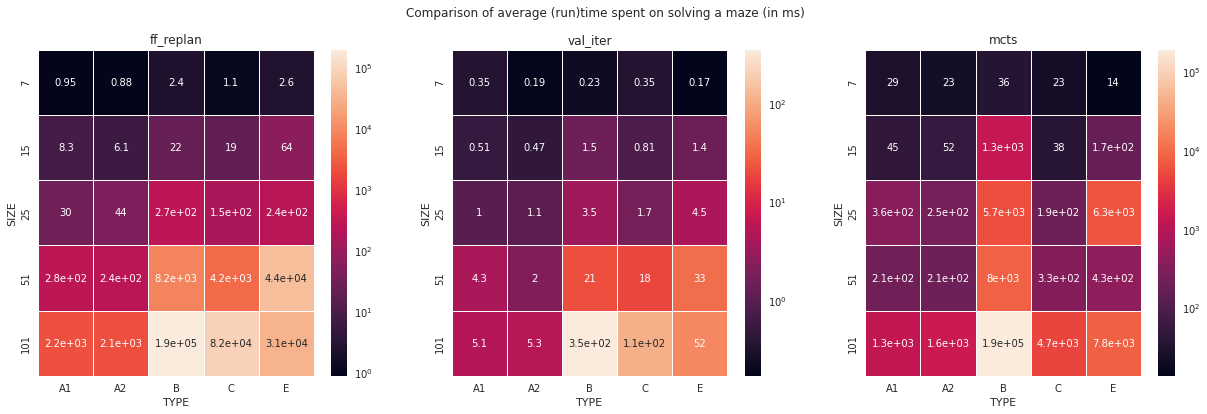

In [14]:
from visualize import plot_time_grid

plot_time_grid(ALGOS, SIZES, TYPES, times, rewards)

NOTE: The color scale is **logarithmic** and **different** for both plots. 

This is intentional, as it helps the argument of showing an intrinsic complexity of the mazes. From this, we can see that the B and C types of mazes (walls are delays / empty space is delay) take the most time. Naturally, if we can walk off track every time (no walls), the FF-replan will need a lot of computation time. 
Interestingly, MCTS seems to perform well on the standard mazes, but when the walls are not present, the potential of prolonging the path is great. 

But still, we see a steeper increase in time demands for FF-replan, compared to VI and MCTS, even on the standard (A1, A2).

Mazes of type E, the special ones, are often also less constrained (more walkable space), posing a difficult task to FF-replan. To MCTS, as mentioned, the unconstrained mazes, those without walls, are the most complex ones. A wrong action is often chosen, leading to increased runtime.

### Rewards
Now, let's turn to rewards. This is a more important comparison to make. Firstly let's show some boxplots on A-type and E-type mazes.

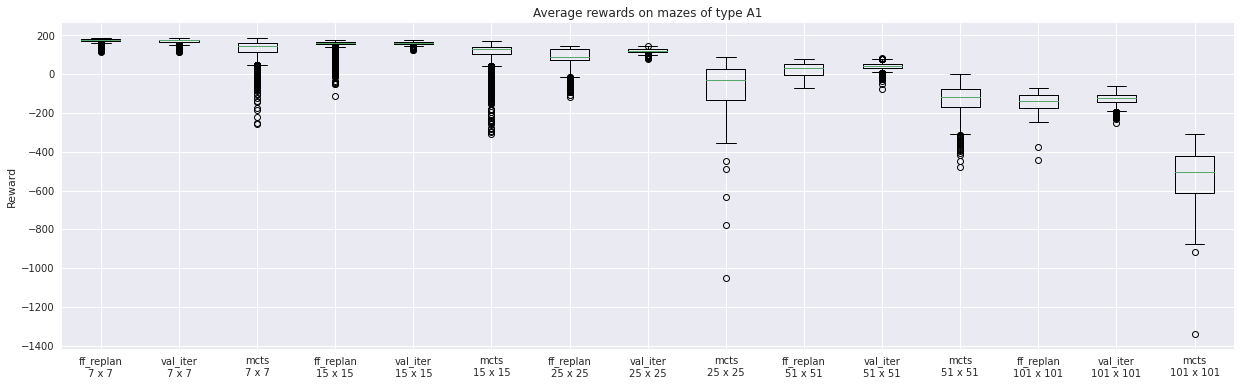

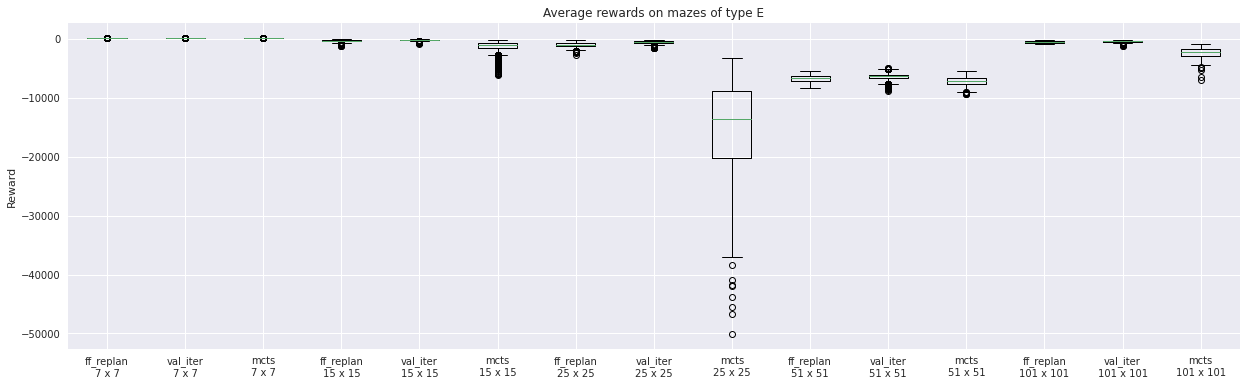

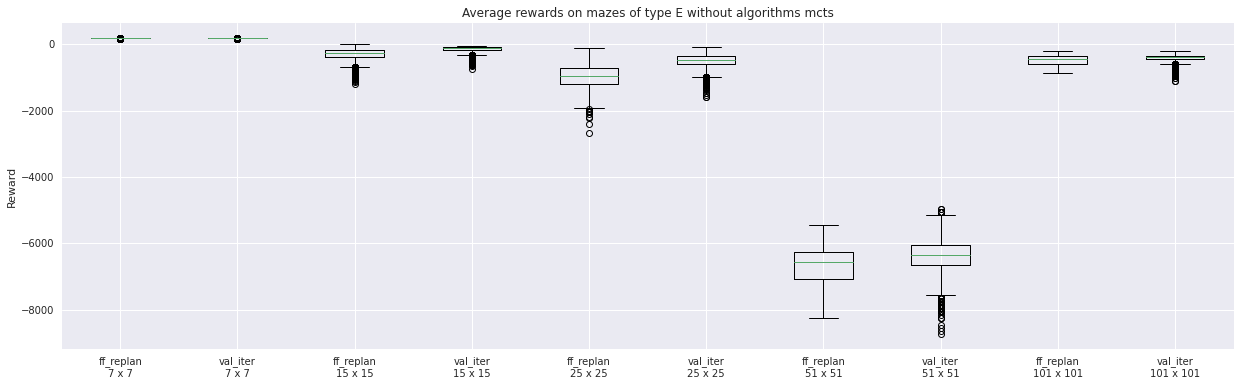

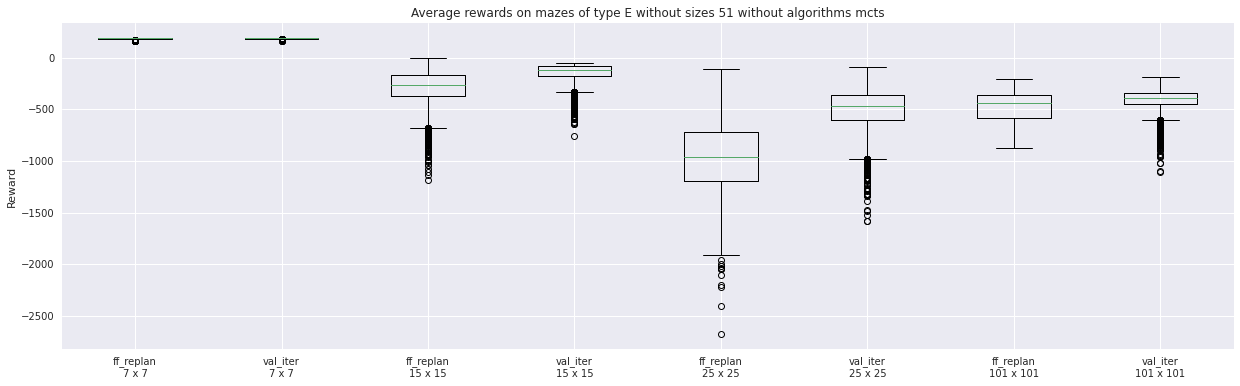

In [15]:
from visualize import show_boxplot_for_type

show_boxplot_for_type(ALGOS, SIZES, TYPES, rewards, "A1")
show_boxplot_for_type(ALGOS, SIZES, TYPES, rewards, "E")
show_boxplot_for_type(ALGOS, SIZES, TYPES, rewards, "E", excluded_algs=["mcts"])
show_boxplot_for_type(ALGOS, SIZES, TYPES, rewards, "E", excluded_sizes=["51"], excluded_algs=["mcts"])

On the mazes of type A, we can clearly see that with the increasing complexity of the maze, VI starts to clearly outperform FF-replan and MCTS. MCTS is falling behind heavily. This points to a problem with the implementation or the hyper-parameters. I assume the problem is with the low number of expansions since the convergence of the agent to the best direction is not reached. 
We also see that the time issues are reflected in the score, pointing to the agent getting lost in the maze, making a lot of steps, decreasing its score, and increasing the time spent in the maze.

On the intricate (E) mazes, we first notice a particularly odd result of MCTS seen in the 2nd plot. That is evidence of the mentioned "getting lost" in the maze. 

When MCTS is removed from the visualization, we notice another oddity on the maze of size 51x51. This is, however, the attribute of the maze. It is a maze that has nothing but delay positions. Here, the VI policy and actions taken by FF-replan should be very similar (as in the 7x7 case, where the maze is empty). The difference might be a byproduct of a lower number of iterations. If we exclude that maze, to see the other boxplots more clearly, a similar thing appears as in the case of A1 mazes.

The VI has higher means and lower variance than FF-replan, as seen from the last plot. I would thus argue that the results clearly side the VI, as expected.

Let me show some numbers too. Firstly, let's look at on how many mazes is VI better than FF-replan / MCTS and by how much.

In [16]:
from visualize import avg_diff

avg_diff(ALGOS, SIZES, TYPES, rewards, "val_iter", "Value Iteration")

Differences of average rewards compared to Value Iteration:

ff_replan
             A1        A2        B         C         E         
7x7:          0.80      1.47      2.90     34.02      0.66
15x15:        4.70      4.78    122.71    128.46    140.33
25x25:       32.75     11.65    146.98    216.19    490.13
51x51:       19.13      4.53    280.04    265.82    278.21
101x101:     20.16     17.45    661.29    786.18     70.12

mcts
             A1        A2        B         C         E         
7x7:         38.98     24.16    200.76    141.94      7.69
15x15:       46.62     71.86  10326.66    330.08    983.99
25x25:      204.33     92.32   8352.32    355.31  15982.01
51x51:      173.78    165.43  29675.03   1456.85    726.73
101x101:    407.40    503.79  69413.40   2041.35   2041.41



We clearly see that in every variant, the VI has the upper hand (though sometimes just marginally). The closest is in the already mentioned 7x7 - E maze that is just empty. This difference might be based on luck, but I would argue it is caused by the way VI works with walls, whereas FF-replan does not take them into account.

More relevant is, however, the relative decrease in performance compared to VI:

In [17]:
from visualize import rel_diff

rel_diff(ALGOS, SIZES, TYPES, rewards, "val_iter", "Value Iteration")

Relative diffferences of average rewards compared to Value Iteration:

ff_replan
             A1      A2      B       C       E       Average
7x7:       0.029   0.063   0.020   0.052   0.050  |   0.043
15x15:     0.119   0.121   0.413   0.085   0.410  |   0.229
25x25:     0.418   0.138   0.367   0.083   0.714  |   0.344
51x51:     0.121   0.028   0.369   0.042   0.042  |   0.120
101x101:   0.062   0.053   0.270   0.066   0.115  |   0.113
------------------------------------------------------------
Average    0.150   0.080   0.288   0.066   0.266
In total, the average relative difference is 0.170

mcts
             A1      A2      B       C       E       Average
7x7:       1.404   1.029   1.387   0.218   0.575  |   0.923
15x15:     1.175   1.817  34.717   0.219   2.877  |   8.161
25x25:     2.610   1.095  20.854   0.136  23.287  |   9.597
51x51:     1.099   1.013  39.079   0.232   0.111  |   8.307
101x101:   1.248   1.526  28.380   0.171   3.356  |   6.936
------------------------------

Here, as could be expected, on B mazes that do not constrain movement, FF-replan is less likely to walk through "walls" that are here just delays. On C mazes, on the other hand, it is mostly about selecting the shortest path, so the difference is not as significant. A similar thing is visible for the MCTS data. Whereas on B mazes, the difference is staggering, results are quite similar on C mazes. Overall, this table supports the assumption that MCTS was not set up well.

Another thing I looked into are the A1 mazes of size 25x25 and 51x51. These are mazes with some delay fields around the shortest deterministic path. But because FF-replan does not take them into account, it likely falls into them from time to time, which leads to a decrease in score. VI chooses a different, longer, but safer route. The bigger the maze is, the lower the relative difference. Because all total rewards are decreasing,  one -50 results in lower and lower relative difference.

## Conclusion
All in all, the VI beats FF-replan and MCTS in every aspect I looked into. This would not be the case for too big state spaces that would not fit in memory, or maybe if we would not know the stochasticity of the environment. But even then, FF-replan seems to beat MCTS, which might only result from limited time spent on testing. When I found the problems with MCTS using a low number of expansions, I had limited time for more testing. What I have seen however, was a dramatic increase in score, even just in moving from 10 to 20. I beleive that to be the cornerstone of the underwhelming MCTS results. Not enough time for proper hyperparameter optimization.

To be honest, I was surprised that the FF-replan does not yield that much worse results relatively compared to VI, given its simplicity.

I am quite sad about my lack of time for the final MCTS implementation since I really wished to play around with the MCTS. The exam period caught up with me, and other responsibilities have a higher priority. I hope you will be sufficiently satisfied with my work.

Thank you. 